# **\[SOLAR_A\]** 연습장 (Batch)

JiyunLim  
2023-08-29

## Import

In [1]:
# modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch geometric
import torch_geometric_temporal
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import GConvLSTM

# torch
import torch
import torch.nn.functional as F

In [2]:
import os
current_directory = os.getcwd()
print(current_directory)

/home/jy/Dropbox/임지윤/noteda_230906/posts/SOLAR

In [7]:
# read dataframe 
df = pd.read_csv('./data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [8]:
# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        edge_weights = np.array(self._dataset["weights"]).T
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset

In [9]:
dict1 = makedict(y)
loader = Loader(dict1)
dataset = loader.get_dataset(lags=24)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [10]:
len(dict1['edges'])

In [11]:
np.array(train_dataset.features).shape, np.array(test_dataset.features).shape

In [12]:
dataset.snapshot_count, train_dataset.snapshot_count, test_dataset.snapshot_count

In [377]:
class GConv_LSTM(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GConv_LSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [378]:
len_tr = train_dataset.snapshot_count
len_test = test_dataset.snapshot_count
print(len_tr, len_test)

2035 509

In [379]:
def get_batches(dataset, len_tr, batch_size=256):
    num_batches =  len_tr // batch_size + (1 if len_tr % batch_size != 0 else 0)
    batches = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batches.append(train_dataset[start_idx:end_idx])
    return batches

In [380]:
batches = get_batches(train_dataset, len_tr, batch_size=128)

In [381]:
model = GConv_LSTM(node_features = 24, filters=16)

In [382]:
model

In [375]:
from tqdm import tqdm

model = GConv_LSTM(node_features = 4, filters=16)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(1)):
    for b, batch in enumerate(batches):
        print(b, np.array(batch.targets).shape, np.array(batch.features).shape)
        # cost = 0
        # for time, snapshot in enumerate(train_dataset):
        #     y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        #     cost = cost + torch.mean((y_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
        #     print(f'\rbatch={b}\t t={time+1}\t loss={cost/(time+1)}\t', end='', flush=True)
        # cost = cost / (time+1)
        # cost.backward()
        # optimizer.step()
        # optimizer.zero_grad()

100%|██████████| 1/1 [00:00<00:00, 184.84it/s]

0 (128, 44) (128, 44, 24)
1 (128, 44) (128, 44, 24)
2 (128, 44) (128, 44, 24)
3 (128, 44) (128, 44, 24)
4 (128, 44) (128, 44, 24)
5 (128, 44) (128, 44, 24)
6 (128, 44) (128, 44, 24)
7 (128, 44) (128, 44, 24)
8 (128, 44) (128, 44, 24)
9 (128, 44) (128, 44, 24)
10 (128, 44) (128, 44, 24)
11 (128, 44) (128, 44, 24)
12 (128, 44) (128, 44, 24)
13 (128, 44) (128, 44, 24)
14 (128, 44) (128, 44, 24)
15 (115, 44) (115, 44, 24)

**feature** : 배치크기 $\times$ 노드 수 $\times$ lag수 // **target** :
배치크기 $\times$ 노드 수

In [367]:
128*15 + 115

In [369]:
train_dataset.snapshot_count

-   전체 trian dataset이 2035개
-   여기서는 배치 사이즈가 128, 미니배치 수가 16개
-   마지막 배치에 들어있는 데이터 수는 다른배치에 들어있는 데이터 수와
    다르다.

즉, 44개의 노드에 대해서 시간 순서대로 128개의 데이터씩 순차적으로
학습한다.

In [383]:
for epoch in tqdm(range(1)):
        cost = 0
        h, c = None, None
        y_hats = []
        for time, snapshot in enumerate(train_dataset[:10]):
            y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            print(y_hat.shape, snapshot.y.shape)
        # print(y_hat.shape, y_hat)
        #     cost = cost + torch.mean((y_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
        #     print(f'\rbatch={b}\t t={time+1}\t loss={cost/(time+1)}\t', end='', flush=True)
        # cost = cost / (time+1)
        # cost.backward()
        # optimizer.step()
        # optimizer.zero_grad()

100%|██████████| 1/1 [00:00<00:00, 24.66it/s]

torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])
torch.Size([44, 1]) torch.Size([44])

------------------------------------------------------------------------

결론?: 학습하는데 시간만 느려지고 아무 의미 없다.. 그냥 에폭별 MSE
안구해도 될 것 같다.

### `-` Try1 (스택을 하는 방법?)

In [190]:
from tqdm import tqdm

model = GConv_LSTM(node_features=4, filters=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

for epoch in tqdm(range(5)):
    for b, batch in enumerate(batches):
        loss = 0
        h, c = None, None
        for t, snapshot in enumerate(batch):
            y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            y_hats = torch.stack([y_hat]).detach().squeeze().float()
            loss = loss + torch.mean((y_hat.reshape(-1) - snapshot.y.reshape(-1))**2)
            print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
        loss = loss / (t+1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Calculate the MSE loss using y_hats and y
    mse_loss = torch.mean((y_hats - y)**2)
    print(f'\repoch {epoch+1}\t: MSE Loss: {mse_loss.item()}\t', end='', flush=True)

  0%|          | 0/5 [00:00<?, ?it/s] 20%|██        | 1/5 [00:11<00:47, 11.93s/it] 40%|████      | 2/5 [00:23<00:34, 11.62s/it] 60%|██████    | 3/5 [00:34<00:22, 11.42s/it] 80%|████████  | 4/5 [00:46<00:11, 11.49s/it]100%|██████████| 5/5 [00:57<00:00, 11.48s/it]

epoch 1 : MSE Loss: 1.457800256569716   12      epoch 2 : MSE Loss: 1.3088601447111 3   43      epoch 3 : MSE Loss: 1.1235545808256533  5       epoch 4 : MSE Loss: 1.04580198028346    3   2       epoch 5 : MSE Loss: 0.988614934759022       6       

In [267]:
from tqdm import tqdm

model = GConv_LSTM(node_features=4, filters=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

mse_losses = []

for epoch in tqdm(range(1)):
    for b, batch in enumerate(batches):
        loss = 0
        h, c = None, None
        for t, snapshot in enumerate(batch):
            y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            y_hats = torch.stack([y_hat]).detach().squeeze().float()
            loss = loss + torch.mean((y_hat.reshape(-1) - snapshot.y.reshape(-1))**2)
            print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
        loss = loss / (t+1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Calculate the MSE loss using y_hats and y
    print(y_hats.shape, y.shape)
    mse_loss = torch.mean((y_hats - y)**2)
    mse_losses.append(mse_loss)
    print(f'\repoch {epoch+1}\t: MSE Loss: {mse_loss.item()}\t', end='', flush=True)

  0%|          | 0/1 [00:00<?, ?it/s]100%|██████████| 1/1 [00:08<00:00,  8.93s/it]

batch=16     t=3     loss=5.252087116241455 7               torch.Size([44]) (2568, 44)
epoch 1 : MSE Loss: 1.5099507182780412  

-   yhat과 snapshot.y를 각각 쌓고 로스를 계산하는 것은 비효율적인 것
    같음.
-   여기서는 차원도 안맞음. (코드 자체가 잘못됨.)

### `-` Try2: 스냅샷 별 로스를 저장??

In [479]:
from tqdm import tqdm

model = GConv_LSTM(node_features=4, filters=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

# best_loss = float('inf')
# patience = 1
mse_losses = []
epochs = 0 

for epoch in tqdm(range(10)):
    snapshot_losses = []
    for b, batch in enumerate(batches):
        loss = 0
        h, c = None, None
        for t, snapshot in enumerate(batch):
            y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            loss = loss + torch.mean((y_hat.reshape(-1) - snapshot.y.reshape(-1))**2)
            snapshot_losses.append(torch.mean((y_hat.reshape(-1) - snapshot.y.reshape(-1))**2).item())
            print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
        loss = loss / (t+1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Calculate the MSE loss using y_hats and y
    mse_loss = np.mean(snapshot_losses)
    mse_losses.append(mse_loss)
    print(mse_loss)
        
    epochs = epochs + 1

#     print(f'\repoch {epoch+1}\t: MSE Loss: {mse_loss.item()}\t', end='', flush=True)
    
#     if mse_loss < best_loss:
#         best_loss = mse_loss
#         early_stop_counter = 0
        
#     else:
#         early_stop_counter += 1
#         if early_stop_counter >= patience:
#             print('Early stopping triggered')
#             break

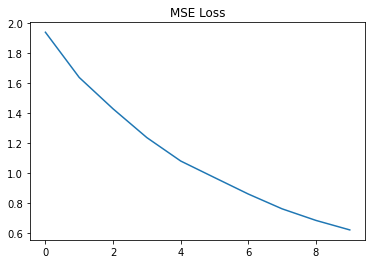

In [256]:
plt.plot(mse_losses)
plt.title('MSE Loss')
plt.show()

In [408]:
yhat.shape

-   생각해보니 이건 틀림. 지금 문제는 배치평균로스가 줄어드는데 여기에만
    의존하다보면 MSE는 이미 최적점을 넘어가있을 수도 있다는 것이다.
    얼리스타핑을 적용시키지 않더라도 MSE가 에폭별 찍히면 좋을 것 같은데…

-   지금 구한 것은 각각 스냅샷에 대한 로스의 평균을 누적한 후 이를 다시
    평균내는 방식인데, 내가 구하고 싶은 MSE는 모든 스냅샷에 대한
    예측값을 계산한 뒤 전체 데이터에 대한 차이의 제곱을 평균낸 값이다.
    이 두가지의 접근방식은 다른 것 같다..

### `-` Try3: list로 저장하여 numpy array로 변환

In [473]:
from tqdm import tqdm

batches = get_batches(train_dataset, len_tr, batch_size=128)
model = GConv_LSTM(node_features=24, filters=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

best_loss = float('inf')
patience = 1
mse_losses = []
epochs = 0 

for epoch in tqdm(range(5)):
    yhat_list = []  # To store yhat for each snapshot
    y_list = []     # To store y for each snapshot
    snapshot_losses = 0
    for b, batch in enumerate(batches):
        loss = 0
        h, c = None, None
        for t, snapshot in enumerate(batch):
            y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            loss = loss + torch.mean((y_hat.reshape(-1) - snapshot.y.reshape(-1))**2)
            yhat_list.append(y_hat.detach().numpy())
            y_list.append(snapshot.y.detach().numpy())
            print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
        loss = loss / (t+1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    mse_loss = np.mean((np.concatenate(yhat_list).reshape(-1,44)- np.concatenate(y_list).reshape(-1,44))**2)
    mse_losses.append(mse_loss)
    print(f'\repoch {epoch+1}\t: MSE Loss: {mse_loss}\t', end='', flush=True)
    epochs = epochs + 1
        
    
#     if mse_loss < best_loss:
#         best_loss = mse_loss
#         early_stop_counter = 0
        
#     else:
#         early_stop_counter += 1
#         if early_stop_counter >= patience:
#             print('Early stopping triggered')
#             break


  0%|          | 0/5 [00:00<?, ?it/s] 20%|██        | 1/5 [00:09<00:36,  9.07s/it] 40%|████      | 2/5 [00:18<00:27,  9.27s/it] 60%|██████    | 3/5 [00:27<00:18,  9.18s/it] 80%|████████  | 4/5 [00:36<00:09,  9.21s/it]100%|██████████| 5/5 [00:46<00:00,  9.24s/it]

epoch 1 : MSE Loss: 0.7102707028388977  4       epoch 2 : MSE Loss: 0.24380207061767578 3   epoch 3 : MSE Loss: 0.16061446070671082 8   epoch 4 : MSE Loss: 0.12691965699195862         epoch 5 : MSE Loss: 0.11027252674102783 8   

In [474]:
np.mean((np.concatenate(yhat_list).reshape(-1,44)- np.concatenate(y_list).reshape(-1,44))**2) #  마지막 에폭의 MSE값과 똑같!

In [475]:
yhat = torch.stack([model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)[0] for snapshot in dataset]).detach().squeeze().float()
yhat[yhat<0] = 0
yhat_ = np.concatenate([np.array([list(yhat[0])]*24), yhat], axis=0)
((y - yhat_)[len_tr:,:]**2).mean()

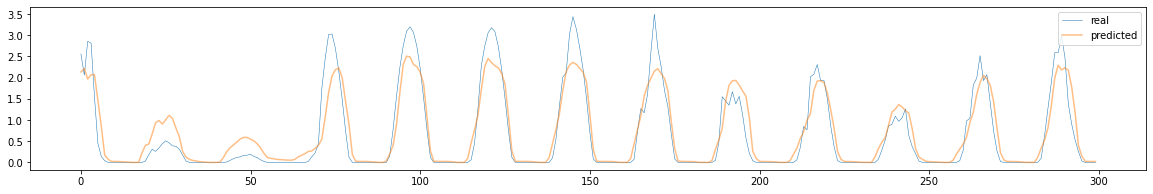

In [476]:
plt.rcParams['figure.figsize'] = [20,3]
plt.plot(y[-300:,0], label='real' , lw=0.5)
plt.plot(yhat_[-300:,0], label='predicted', alpha=0.5)
plt.legend()
plt.show()

### `-` Try3: 10에폭

In [483]:
from tqdm import tqdm

batches = get_batches(train_dataset, len_tr, batch_size=128)
model = GConv_LSTM(node_features=24, filters=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

# best_loss = float('inf')
# patience = 1
mse_losses = []
epochs = 0 

for epoch in tqdm(range(10)):
    yhat_list = []  # To store yhat for each snapshot
    y_list = []     # To store y for each snapshot
    for b, batch in enumerate(batches):
        loss = 0
        h, c = None, None
        for t, snapshot in enumerate(batch):
            y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            loss = loss + torch.mean((y_hat.reshape(-1) - snapshot.y.reshape(-1))**2)
            yhat_list.append(y_hat.detach().numpy())
            y_list.append(snapshot.y.detach().numpy())
            print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
        loss = loss / (t+1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    mse_loss = np.mean((np.concatenate(yhat_list).reshape(-1,44)- np.concatenate(y_list).reshape(-1,44))**2)
    mse_losses.append(mse_loss)
    print(f'\repoch {epoch+1}\t: MSE Loss: {mse_loss}\t', end='', flush=True)
    epochs = epochs + 1
        
    
#     if mse_loss < best_loss:
#         best_loss = mse_loss
#         early_stop_counter = 0
        
#     else:
#         early_stop_counter += 1
#         if early_stop_counter >= patience:
#             print('Early stopping triggered')
#             break


  0%|          | 0/10 [00:00<?, ?it/s] 10%|█         | 1/10 [00:09<01:22,  9.13s/it] 20%|██        | 2/10 [00:18<01:12,  9.12s/it] 30%|███       | 3/10 [00:27<01:03,  9.10s/it] 40%|████      | 4/10 [00:36<00:55,  9.18s/it] 50%|█████     | 5/10 [00:45<00:45,  9.12s/it] 60%|██████    | 6/10 [00:54<00:36,  9.19s/it] 70%|███████   | 7/10 [01:03<00:27,  9.13s/it] 80%|████████  | 8/10 [01:12<00:18,  9.09s/it] 90%|█████████ | 9/10 [01:21<00:09,  9.03s/it]100%|██████████| 10/10 [01:30<00:00,  9.10s/it]

epoch 1 : MSE Loss: 0.920889139175415   514 epoch 2 : MSE Loss: 0.3255065679550171  23  epoch 3 : MSE Loss: 0.2083916813135147  36      epoch 4 : MSE Loss: 0.15126584470272064         epoch 5 : MSE Loss: 0.12060346454381943 2   epoch 6 : MSE Loss: 0.10596444457769394 2   epoch 7 : MSE Loss: 0.09914860129356384 8   epoch 8 : MSE Loss: 0.09589444845914841 3   epoch 9 : MSE Loss: 0.09170856326818466 2   epoch 10    : MSE Loss: 0.09004269540309906     

In [484]:
np.mean((np.concatenate(yhat_list).reshape(-1,44)- np.concatenate(y_list).reshape(-1,44))**2) #  마지막 에폭의 MSE값과 똑같!

In [485]:
yhat = torch.stack([model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)[0] for snapshot in dataset]).detach().squeeze().float()
yhat[yhat<0] = 0
yhat_ = np.concatenate([np.array([list(yhat[0])]*24), yhat], axis=0)
((y - yhat_)[len_tr:,:]**2).mean()

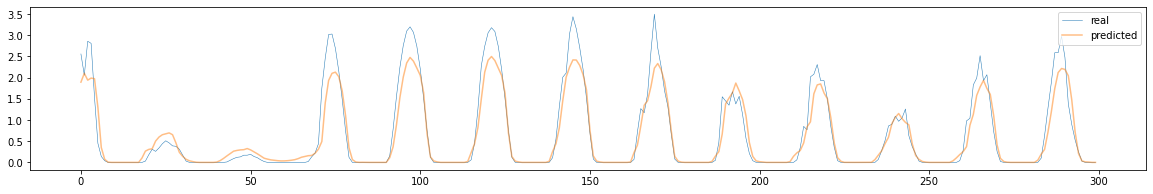

In [486]:
plt.rcParams['figure.figsize'] = [20,3]
plt.plot(y[-300:,0], label='real' , lw=0.5)
plt.plot(yhat_[-300:,0], label='predicted', alpha=0.5)
plt.legend()
plt.show()

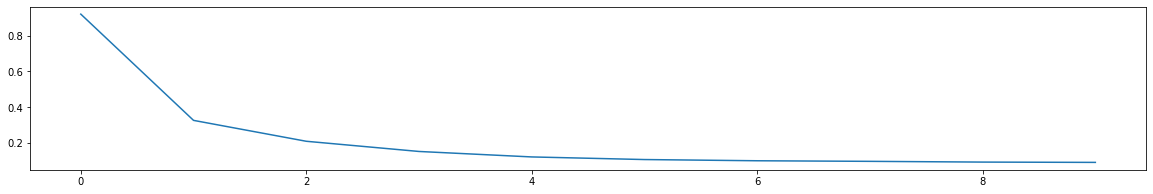

In [488]:
plt.plot(mse_losses)

-   y, yP의 에폭은 학습률 0.01에서 10정도로 고정시키면 될 것 같다.

### `-` Try3 + Proposed

In [60]:
dict2, dict3 = makedict(yU), makedict(yP)
loader2, loader3 = Loader(dict2), Loader(dict3)
dataset2 = loader2.get_dataset(lags=4)
dataset3 = loader3.get_dataset(lags=24)
train_dataset2, test_dataset2 = temporal_signal_split(dataset2, train_ratio=0.8)
train_dataset3, test_dataset3 = temporal_signal_split(dataset3, train_ratio=0.8)

In [61]:
np.array(train_dataset2.features).shape, np.array(test_dataset2.features).shape

In [62]:
dataset2.snapshot_count, train_dataset2.snapshot_count, test_dataset2.snapshot_count

In [63]:
class GConv_LSTM(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GConv_LSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

In [64]:
def get_batches(train_dataset, len_tr, batch_size=256):
    num_batches =  len_tr // batch_size + (1 if len_tr % batch_size != 0 else 0)
    batches = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batches.append(train_dataset[start_idx:end_idx])
    return batches

In [65]:
len_tr = train_dataset2.snapshot_count
len_tr

`-` yU

In [ ]:
from tqdm import tqdm

batches = get_batches(train_dataset2, len_tr, batch_size=128)
model_yU = GConv_LSTM(node_features=4, filters=16)
optimizer = torch.optim.Adam(model_yU.parameters(), lr=0.01)
model_yU.train()

# best_loss = float('inf')
# patience = 1
mse_losses = []
epochs = 0 

for epoch in tqdm(range(10)):
    yhat_list = []  # To store yhat for each snapshot
    y_list = []     # To store y for each snapshot
    for b, batch in enumerate(batches):
        loss = 0
        h, c = None, None
        for t, snapshot in enumerate(batch):
            y_hat, h, c = model_yU(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            loss = loss + torch.mean((y_hat.reshape(-1) - snapshot.y.reshape(-1))**2)
            # yhat_list.append(y_hat.detach().numpy())
            # y_list.append(snapshot.y.detach().numpy())
            print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
        loss = loss / (t+1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # mse_loss = np.mean((np.concatenate(yhat_list).reshape(-1,44)- np.concatenate(y_list).reshape(-1,44))**2)
    # mse_losses.append(mse_loss)
    # print(f'\repoch {epoch+1}\t: MSE Loss: {mse_loss}\t', end='', flush=True)
    # epochs = epochs + 1
    
#     if mse_loss < best_loss:
#         best_loss = mse_loss
#         early_stop_counter = 0
        
#     else:
#         early_stop_counter += 1
#         if early_stop_counter >= patience:
#             print('Early stopping triggered')
#             break

  0%|          | 0/10 [00:00<?, ?it/s] 10%|█         | 1/10 [00:08<01:20,  8.91s/it] 20%|██        | 2/10 [00:17<01:11,  8.88s/it] 30%|███       | 3/10 [00:26<01:01,  8.85s/it] 40%|████      | 4/10 [00:35<00:53,  8.87s/it] 50%|█████     | 5/10 [00:44<00:44,  8.86s/it] 60%|██████    | 6/10 [00:53<00:35,  8.82s/it]

batch=16     t=3     loss=2.825490713119507     2   batch=16     t=3     loss=0.8137820363044739    6   batch=16     t=3     loss=0.4575939178466797    67  batch=16     t=3     loss=0.33036595582962036   3   batch=16     t=3     loss=0.24059593677520752   74  batch=16     t=3     loss=0.19701212644577026   68  batch=9  t=59    loss=0.0318136140704155    6       

In [76]:
yUhat = torch.stack([model_yU(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)[0] for snapshot in dataset2]).detach().squeeze().float()
yUhat_ = np.concatenate([np.array([list(yUhat[0])]*4), yUhat], axis=0)
((yU - yUhat_)[len_tr:,:]**2).mean()

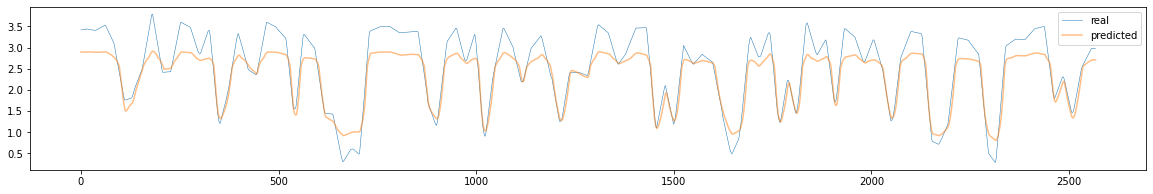

In [77]:
plt.rcParams['figure.figsize'] = [20,3]
plt.plot(yU[:,0], label='real' , lw=0.5)
plt.plot(yUhat_[:,0], label='predicted', alpha=0.5)
plt.legend()
plt.show()